In [1]:
import torch as torch
from network.metric.accuracy import acc_srcnn_tiny_radar
from network.models.classifiers.tiny_radar import TinyRadarNN
from network.models.sr_classifier.SRCnnTinyRadar import CombinedSRCNNClassifier
from network.models.super_resolution.drln import Drln
from network.models.super_resolution.srcnn import SRCnn
from network.runner import Runner
from utils.utils_paths import get_time_in_string
from utils.utils_images import Normalization
import os
import cv2
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift, ifftshift, ifft
from functools import partial
from multiprocessing import Pool
from data_loader.tiny_loader import load_tiny_data_sr
from data_loader.tiny_loader import *
from data_loader.tiny_radar_loader import tiny_radar_for_classifier, tiny_tt




In [33]:
from torch.utils.data import DataLoader, Dataset

class DopplerDataset(Dataset):
    def __init__(self, imgs):
        self.imgs = imgs
    
    def process_data(self, x:np.ndarray) -> np.ndarray:
        x = np.abs(fftshift(fft(x, axis=0), axes=0))
        x = normalize_img(x,Normalization.Range_0_1)
        x = np.expand_dims(x, axis=0)
        return x

    def __len__(self):
        return self.imgs.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        high_res_time = self.imgs[idx]
        high_res = np.abs(fftshift(fft(high_res_time, axis=0), axes=0))
        high_res = normalize_img(high_res,Normalization.Range_0_1)
        high_res = np.expand_dims(high_res, axis=0)
        low_res_time = down_sample_img(high_res_time,4,4)
        low_res = np.abs(fftshift(fft(low_res_time, axis=0), axes=0))
        low_res = normalize_img(low_res,Normalization.Range_0_1)
        low_res = np.expand_dims(low_res, axis=0)
        return low_res, high_res



In [34]:
numberOfInstanceWindows = 3
lengthOfSubWindow = 32

gestures = [
        "PinchIndex",
        "PinchPinky",
        # "FingerSlider",
        # "FingerRub",
        # "SlowSwipeRL",
        # "FastSwipeRL",
        # "Push",
        # "Pull",
        # "PalmTilt",
        # "Circle",
        # "PalmHold",
        # "NoHand",
    ]
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/data_feat/"
data_dir1 = "/Users/netanelblumenfeld/Desktop/data/11G/data_npy/"
output_dir = "/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs"

people = 4

In [28]:
from data_loader.tiny_radar_loader import tiny_radar_for_classifier, tiny_tt
from training_scripts.training_sr import train_drln



# data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
# high,low,name = tiny_tt(data_dir, 3, gestures,8,Normalization.Range_0_1)

data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"
paths = data_paths(data_dir, people, gestures,"npy")
data = feat_sr_reshape(npy_feat_reshape(load_data(paths[0])))
data.shape


(1050, 32, 492)

In [35]:
data_dir = "/Users/netanelblumenfeld/Desktop/data/11G/"

data = load_tiny_data(data_dir, people, gestures,"npy")
data.shape


loading data with 8 cpu cores
concatenating data


(6300, 32, 492)

In [36]:
dataset = ReconstractDataset(data)
trainloader = DataLoader(dataset, batch_size=8, shuffle=True)


In [37]:
for x,y in trainloader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([8, 1, 8, 123])
torch.Size([8, 1, 32, 492])


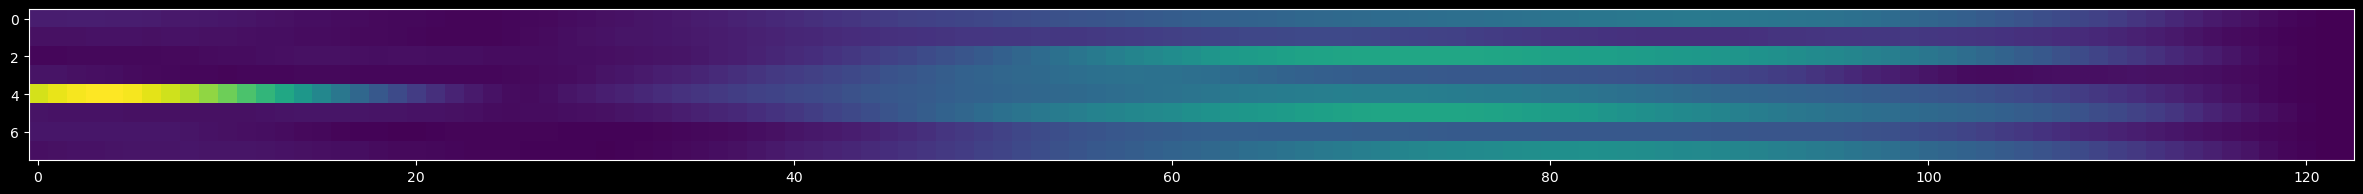

In [38]:
plt.figure(figsize=(30,30))
plt.imshow(x[0,0])


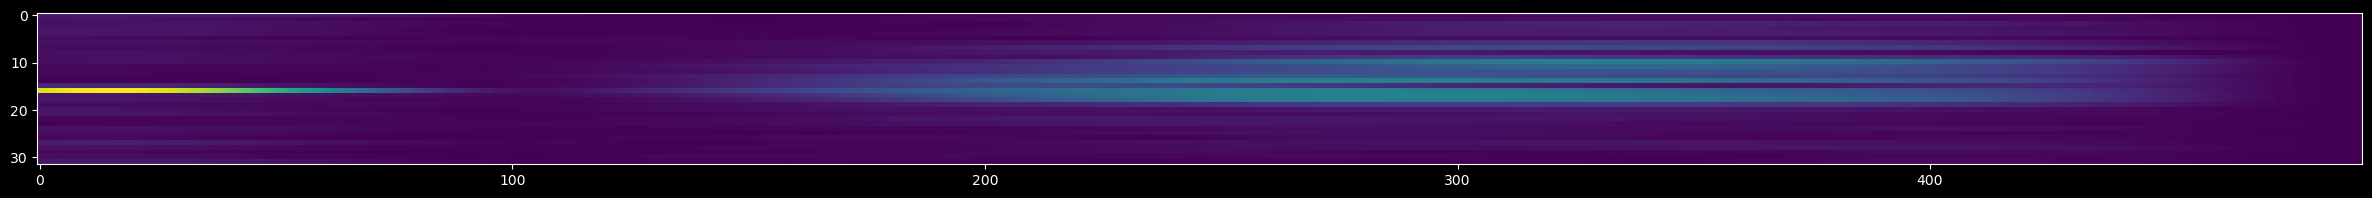

In [39]:
plt.figure(figsize=(30,30))
plt.imshow(y[0,0])


In [12]:
m = Drln(2)
path="/Users/netanelblumenfeld/Desktop/bgu/Msc/project/outputs/models/sr/Drln_2/11G_normalization.range_0_1/lr_0.0005_batch_size_128_loss_L1/2023-12-27_13:39:19min_loss_model.pt"
m.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

In [25]:
x.shape

torch.Size([8, 1, 8, 123])

In [22]:


res = m(x)
res.shape

torch.Size([8, 1, 32, 492])

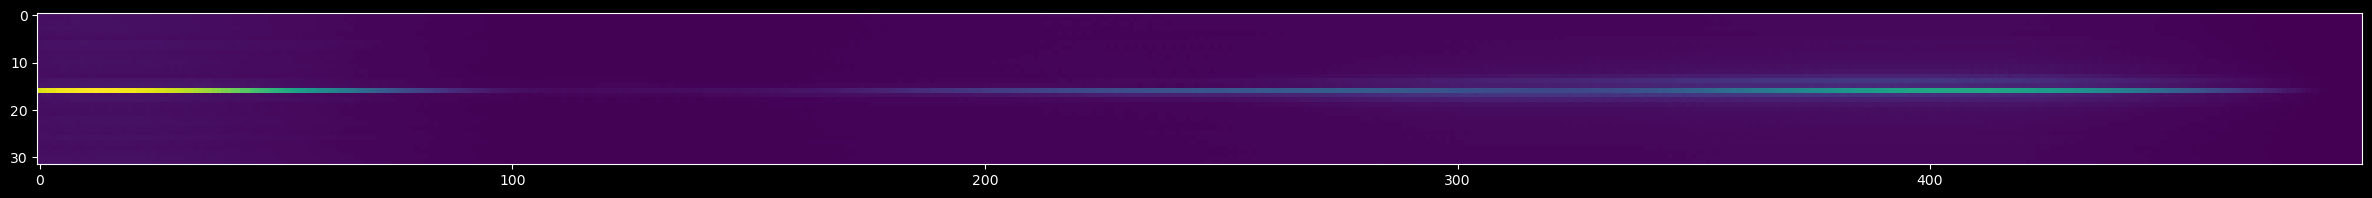

In [42]:
plt.figure(figsize=(30,30))
plt.imshow(res[3,0].detach().numpy())